<a href="https://colab.research.google.com/github/aegisen/DATA441/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and Setups

In [3]:
!pip install -q scikit-learn-intelex

In [4]:
!pip install usearch

In [5]:
!pip install fastkde


In [6]:
!pip install sklearnex

ERROR: Could not find a version that satisfies the requirement sklearnex (from versions: none)
ERROR: No matching distribution found for sklearnex


In [7]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearnex import patch_sklearn
patch_sklearn()
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report as CR
import warnings
warnings.simplefilter(action='ignore')


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [8]:
import usearch

In [9]:
import fastkde

#Setup Data for Model

In [10]:
# define dataset
x, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=444)


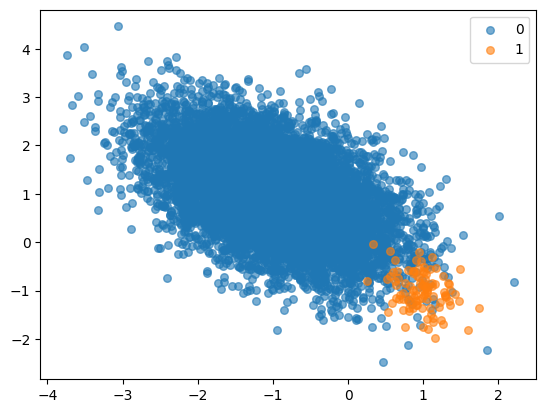

In [11]:
# scatter plot of examples by class label
counter = Counter(y)

for label, _ in counter.items():
	row_ix = np.where(y == label)[0]
	plt.scatter(x[row_ix, 0], x[row_ix, 1], label=str(label),alpha=0.6,s=30)
plt.legend()
plt.show()

## SMOTE Dataset

Counter({0: 9900, 1: 9900})


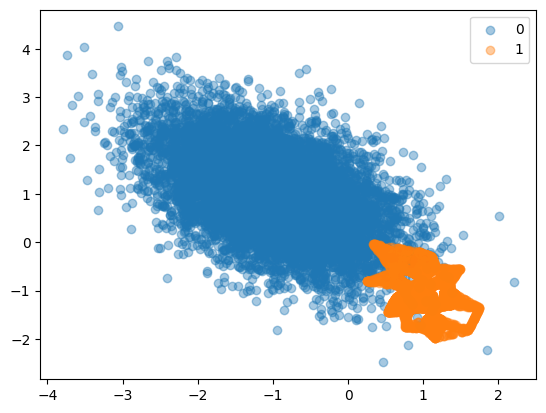

In [12]:
oversample = SMOTE()
x_SMOTE, y_SMOTE = oversample.fit_resample(x, y)
# summarize the new class distribution
counter = Counter(y_SMOTE)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = np.where(y_SMOTE == label)[0]
	plt.scatter(x_SMOTE[row_ix, 0], x_SMOTE[row_ix, 1], label=str(label),alpha=0.4)
plt.legend()
plt.show()

## ADASYN Dataset

Counter({0: 9900, 1: 9890})


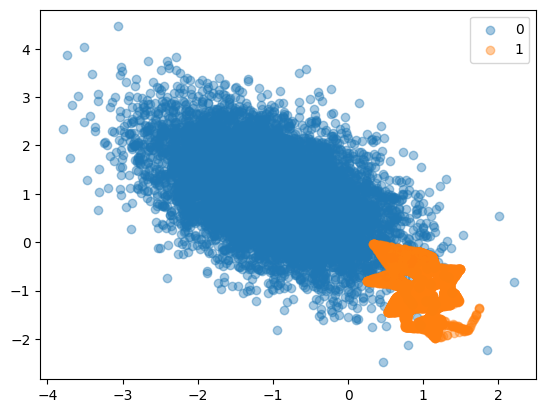

In [13]:
ada = ADASYN(random_state=444)
x_ADASYN, y_ADASYN = ada.fit_resample(x, y)
# summarize the new class distribution
counter = Counter(y_ADASYN)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = np.where(y_ADASYN == label)[0]
	plt.scatter(x_ADASYN[row_ix, 0], x_ADASYN[row_ix, 1], label=str(label),alpha=0.4)
plt.legend()
plt.show()


## FastKDE Dataset

In [14]:
minority_features = x[y==1]
minority_features

array([[ 1.13119114, -1.55870511],
       [ 1.48723878, -0.5460318 ],
       [ 0.62399441, -0.79171956],
       [ 0.55341343, -0.70696975],
       [ 0.80313412, -1.18894688],
       [ 0.98312193, -1.35249734],
       [ 1.08761215, -1.35157343],
       [ 0.99617877, -0.59799898],
       [ 1.01691359, -0.5073581 ],
       [ 1.11854882, -0.84400602],
       [ 1.28553544, -1.09784559],
       [ 1.28500459, -1.10998352],
       [ 1.02605335, -0.75291645],
       [ 1.11244787, -0.30019645],
       [ 0.95747298, -0.83157921],
       [ 1.05514334, -1.16827814],
       [ 0.73466926, -1.04684578],
       [ 0.69367737, -1.08137795],
       [ 0.73724374, -1.16673971],
       [ 1.35505624, -0.98928944],
       [ 1.1325762 , -1.63820257],
       [ 0.89936921, -1.21244487],
       [ 1.42122547, -1.06903812],
       [ 0.80722024, -1.23936422],
       [ 0.63879752, -1.1430132 ],
       [ 0.95036901, -0.71274658],
       [ 1.27593092, -1.02123042],
       [ 1.22710952, -1.23090327],
       [ 0.90586169,

In [15]:
lb = minority_features.min(axis=0)
ub = minority_features.max(axis=0)

In [16]:
# Generate a lot of points between lb and ub
testpoints = np.random.uniform(low=lb,high=ub, size=(10000,2))

In [17]:
testpoints

array([[ 0.31756683, -0.58755105],
       [ 1.00295924, -0.23553442],
       [ 0.52184371, -0.39834348],
       ...,
       [ 0.54781107, -0.43904749],
       [ 0.72058109, -0.5855732 ],
       [ 1.41932561, -1.49019005]])

In [18]:
pdf = fastkde.pdf_at_points(minority_features[:,0],minority_features[:,1],list_of_points=testpoints,num_points=2**9+1)

In [19]:
# get the better fakes
fakes = testpoints[pdf>np.percentile(pdf,65)]

Counter({0.0: 9900, 1.0: 3600})


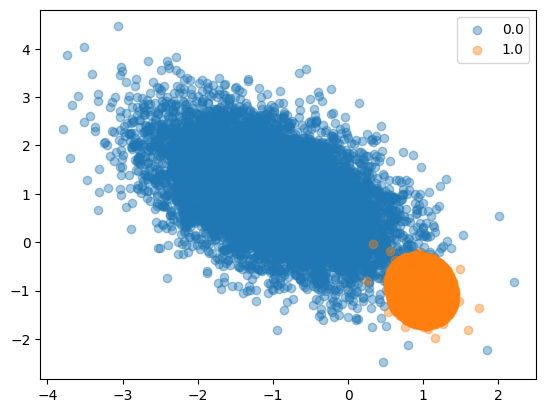

In [20]:
x_FastKDE = np.row_stack([x, fakes])
y_FastKDE = np.concatenate([y, np.ones(len(fakes))])

# summarize the new class distribution
counter = Counter(y_FastKDE)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = np.where(y_FastKDE == label)[0]
	plt.scatter(x_FastKDE[row_ix, 0], x_FastKDE[row_ix, 1], label=str(label),alpha=0.4)
plt.legend()
plt.show()

# Define KNN Model

In [21]:
from usearch.index import Index, MetricKind, search
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import mean_squared_error as mse

In [49]:
class USearchKNN:
  def __init__(self, k = 3):
    self.k = k
    self.index = None

  def fit(self, x, y):
    self.x = x
    self.y = y

    self.index = Index(ndim = self.x.shape[1], metric = MetricKind.Cos, expansion_search=64)
    self.index.add(np.arange(len(self.x)), self.x)

  def predict(self, x):
    preds = []
    for item in x:
      pair = self.index.search(item.reshape(1, -1), count = self.k)
      index = pair.keys

      pred = np.mean(self.y[index])
      preds.append(pred.round()) # Round because classification

    return preds


# Evaluating MSE on KNN Model

## Scaling Data

In [23]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
scale = StandardScaler()

# Regular Data
xscaled = scale.fit_transform(x)

# SMOTE
x_SMOTE_scaled = scale.fit_transform(x_SMOTE)

# ADASYN
x_ADASYN_scaled = scale.fit_transform(x_ADASYN)


# FastKDE
x_FastKDE_scaled = scale.fit_transform(x_FastKDE)

## Split Data

In [24]:
from sklearn.model_selection import train_test_split

# Regular
x_train, x_test, y_train, y_test = train_test_split(xscaled, y, test_size=0.33, random_state = 444)

# SMOTE
x_SMOTE_train, x_SMOTE_test, y_SMOTE_train, y_SMOTE_test = train_test_split(x_SMOTE_scaled, y_SMOTE, test_size=0.33, random_state = 444)

# ADASYN
x_ADASYN_train, x_ADASYN_test, y_ADASYN_train, y_ADASYN_test = train_test_split(x_ADASYN_scaled, y_ADASYN, test_size=0.33, random_state = 444)


# FastKDE
x_FastKDE_train, x_FastKDE_test, y_FastKDE_train, y_FastKDE_test = train_test_split(x_FastKDE_scaled, y_FastKDE, test_size=0.33, random_state = 444)



## On Regular Data

In [50]:
# Train model and predict
usearch = USearchKNN(k=2)

usearch.fit(x_train, y_train)

y_pred = usearch.predict(x_test)

print("MSE for original data: ", mse(y_pred, y_test))

MSE for original data:  0.009696969696969697


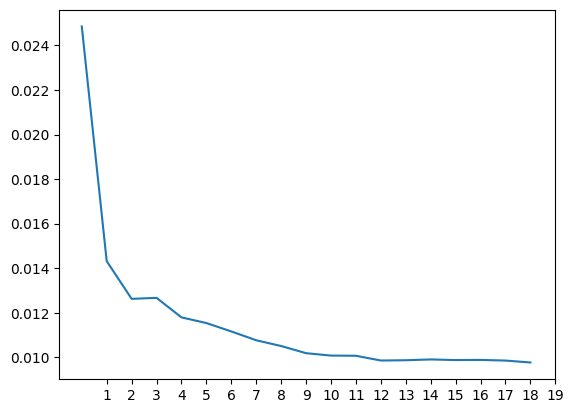

In [35]:
# Train model and predict
mses = []

for k in range(1,20):
  usearch = USearchKNN(k=k)

  usearch.fit(x_train, y_train)

  y_pred = usearch.predict(x_test)

  #print("MSE for SMOTE, : ", mse(y_pred, y_SMOTE_test))
  mses.append(mse(y_pred, y_test))

plt.plot(mses)
plt.xticks(np.arange(1, 20, step=1))
plt.show()

Around k=12 looks good

In [38]:
usearch = USearchKNN(k=12)

usearch.fit(x_train, y_train)

y_pred = usearch.predict(x_test)

print("MSE for SMOTE, K = 15: ", mse(y_pred, y_test))

MSE for SMOTE, K = 15:  0.01007154882154882


## On SMOTE

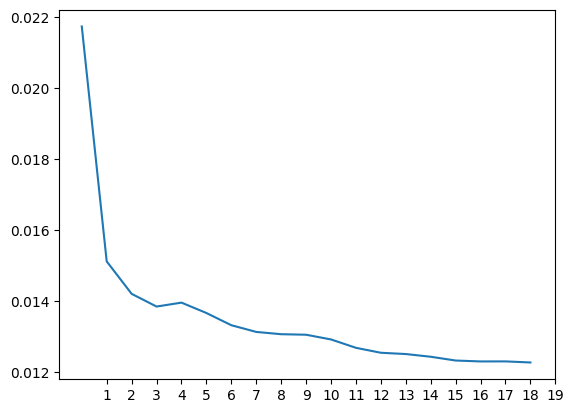

In [32]:
# Train model and predict
mses = []

for k in range(1,20):
  usearch = USearchKNN(k=k)

  usearch.fit(x_SMOTE_train, y_SMOTE_train)

  y_pred = usearch.predict(x_SMOTE_test)

  #print("MSE for SMOTE, : ", mse(y_pred, y_SMOTE_test))
  mses.append(mse(y_pred, y_SMOTE_test))

plt.plot(mses)
plt.xticks(np.arange(1, 20, step=1))
plt.show()

Around k=15 looks good

In [34]:
usearch = USearchKNN(k=15)

usearch.fit(x_SMOTE_train, y_SMOTE_train)

y_pred = usearch.predict(x_SMOTE_test)

print("MSE for SMOTE, K = 15: ", mse(y_pred, y_SMOTE_test))

MSE for SMOTE, K = 15:  0.012426623133693838


## On ADASYN

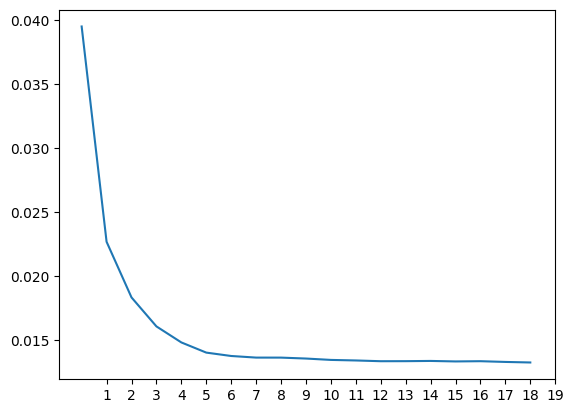

In [39]:
# Train model and predict
mses = []

for k in range(1,20):
  usearch = USearchKNN(k=k)

  usearch.fit(x_ADASYN_train, y_ADASYN_train)

  y_pred = usearch.predict(x_ADASYN_test)

  mses.append(mse(y_pred, y_ADASYN_test))

plt.plot(mses)
plt.xticks(np.arange(1, 20, step=1))
plt.show()

Looks best around K=9

In [40]:
usearch = USearchKNN(k=9)

usearch.fit(x_ADASYN_train, y_ADASYN_train)

y_pred = usearch.predict(x_ADASYN_test)

print("MSE for ADASYN, K = 15: ", mse(y_pred, y_ADASYN_test))

MSE for ADASYN, K = 15:  0.01359707076034336


## On FastKDE

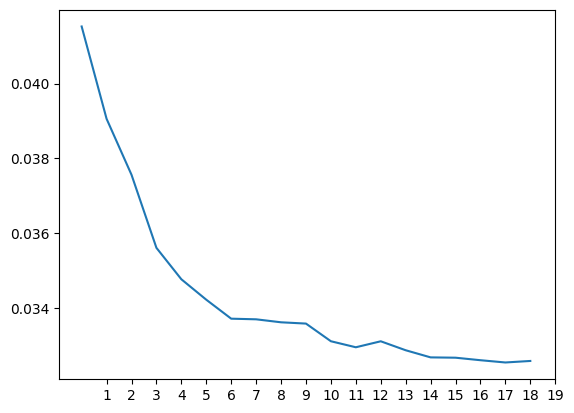

In [41]:
# Train model and predict
mses = []

for k in range(1,20):
  usearch = USearchKNN(k=k)

  usearch.fit(x_FastKDE_train, y_FastKDE_train)

  y_pred = usearch.predict(x_FastKDE_test)

  mses.append(mse(y_pred, y_FastKDE_test))

plt.plot(mses)
plt.xticks(np.arange(1, 20, step=1))
plt.show()

Looks best around K=17

In [42]:
usearch = USearchKNN(k=17)

usearch.fit(x_ADASYN_train, y_ADASYN_train)

y_pred = usearch.predict(x_ADASYN_test)

print("MSE for ADASYN, K = 15: ", mse(y_pred, y_ADASYN_test))

MSE for ADASYN, K = 15:  0.013317905183635778


# Final Results/Discussion: Accuracy, Precision, Recall, F1

Putting everything together

In [53]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


In [76]:
# Train model and predict

normal_accuracy = []
SMOTE_accuracy = []
ADASYN_accuracy = []
FastKDE_accuracy = []

normal_precision = []
SMOTE_precision = []
ADASYN_precision = []
FastKDE_precision = []

normal_recall = []
SMOTE_recall = []
ADASYN_recall = []
FastKDE_recall = []

normal_f1 = []
SMOTE_f1 = []
ADASYN_f1 = []
FastKDE_f1 = []



for k in range(1,21):
  usearch = USearchKNN(k=k)
  #print(k)

  # For normal data
  usearch.fit(x_train, y_train)

  y_pred = usearch.predict(x_test)

  normal_accuracy.append(accuracy_score(y_test, y_pred))
  normal_precision.append(precision_score(y_test, y_pred))
  normal_recall.append(recall_score(y_test, y_pred))
  normal_f1.append(f1_score(y_test, y_pred))


  # For SMOTE
  usearch.fit(x_SMOTE_train, y_SMOTE_train)

  y_SMOTE_pred = usearch.predict(x_SMOTE_test)

  SMOTE_accuracy.append(accuracy_score(y_SMOTE_test, y_SMOTE_pred))
  SMOTE_precision.append(precision_score(y_SMOTE_test, y_SMOTE_pred))
  SMOTE_recall.append(recall_score(y_SMOTE_test, y_SMOTE_pred))
  SMOTE_f1.append(f1_score(y_SMOTE_test, y_SMOTE_pred))


  # For ADASYN
  usearch.fit(x_ADASYN_train, y_ADASYN_train)

  y_ADASYN_pred = usearch.predict(x_ADASYN_test)

  ADASYN_accuracy.append(accuracy_score(y_ADASYN_test, y_ADASYN_pred))
  ADASYN_precision.append(precision_score(y_ADASYN_test, y_ADASYN_pred))
  ADASYN_recall.append(recall_score(y_ADASYN_test, y_ADASYN_pred))
  ADASYN_f1.append(f1_score(y_ADASYN_test, y_ADASYN_pred))


  # For FastKDE
  usearch.fit(x_FastKDE_train, y_FastKDE_train)

  y_FastKDE_pred = usearch.predict(x_FastKDE_test)

  FastKDE_accuracy.append(accuracy_score(y_FastKDE_test, y_FastKDE_pred))
  FastKDE_precision.append(precision_score(y_FastKDE_test, y_FastKDE_pred))
  FastKDE_recall.append(recall_score(y_FastKDE_test, y_FastKDE_pred))
  FastKDE_f1.append(f1_score(y_FastKDE_test, y_FastKDE_pred))

# Info for normal
print("*** NORMAL DATA ***")
print("Best Accuracy for Normal: k =", normal_accuracy.index(max(normal_accuracy))+1, "; Accuracy =", max(normal_accuracy))
print("Best Precision for Normal: k =", normal_precision.index(max(normal_precision))+1, "; Precision =", max(normal_precision))
print("Best Recall for Normal: k =", normal_precision.index(max(normal_precision))+1, "; Precision =", max(normal_precision))
print("Best F1 for Normal: k =", normal_f1.index(max(normal_f1))+1, "F1 = ", max(normal_f1))
print("\n\n")

print("*** SMOTE DATA ***")
print("Best Accuracy for SMOTE: k =", SMOTE_accuracy.index(max(SMOTE_accuracy))+1, "; Accuracy =", max(SMOTE_accuracy))
print("Best Precision for SMOTE: k =", SMOTE_precision.index(max(SMOTE_precision))+1, "; Precision =", max(SMOTE_precision))
print("Best Recall for SMOTE: k =", SMOTE_precision.index(max(SMOTE_precision))+1, ", Precision =", max(SMOTE_precision))
print("Best F1 for SMOTE: k =", SMOTE_f1.index(max(SMOTE_f1))+1, "F1 = ", max(SMOTE_f1))
print("\n\n")

print("*** ADASYN DATA ***")
print("Best Accuracy for ADASYN: k =", ADASYN_accuracy.index(max(ADASYN_accuracy))+1, "; Accuracy =", max(ADASYN_accuracy))
print("Best Precision for ADASYN: k =", ADASYN_precision.index(max(ADASYN_precision))+1, ", Precision =", max(ADASYN_precision))
print("Best Recall for ADASYN: k =", ADASYN_precision.index(max(ADASYN_precision))+1, "; Precision =", max(ADASYN_precision))
print("Best F1 for ADASYN: k =", ADASYN_f1.index(max(ADASYN_f1))+1, "F1 = ", max(ADASYN_f1))
print("\n\n")

print("*** FastKDE DATA ***")
print("Best Accuracy for FastKDE: k =", FastKDE_accuracy.index(max(FastKDE_accuracy))+1, "; Accuracy =", max(FastKDE_accuracy))
print("Best Precision for FastKDE: k =", FastKDE_precision.index(max(FastKDE_precision))+1, ", Precision =", max(FastKDE_precision))
print("Best Recall for FastKDE: k =", FastKDE_precision.index(max(FastKDE_precision))+1, "; Precision =", max(FastKDE_precision))
print("Best F1 for FastKDE: k =", FastKDE_f1.index(max(FastKDE_f1))+1, "; F1 = ", max(FastKDE_f1))
print("\n\n")

*** NORMAL DATA ***
Best Accuracy for Normal: k = 2 ; Accuracy = 0.9903030303030304
Best Precision for Normal: k = 1 ; Precision = 0.08333333333333333
Best Recall for Normal: k = 1 ; Precision = 0.08333333333333333
Best F1 for Normal: k = 1 F1 =  0.10869565217391304



*** SMOTE DATA ***
Best Accuracy for SMOTE: k = 3 ; Accuracy = 0.9871441689623508
Best Precision for SMOTE: k = 2 ; Precision = 0.9769972023624495
Best Recall for SMOTE: k = 2 , Precision = 0.9769972023624495
Best F1 for SMOTE: k = 3 F1 =  0.9871441689623508



*** ADASYN DATA ***
Best Accuracy for ADASYN: k = 6 ; Accuracy = 0.986985147756852
Best Precision for ADASYN: k = 6 , Precision = 0.9749698431845597
Best Recall for ADASYN: k = 6 ; Precision = 0.9749698431845597
Best F1 for ADASYN: k = 6 F1 =  0.9870248816974507



*** FastKDE DATA ***
Best Accuracy for FastKDE: k = 8 ; Accuracy = 0.9643097643097643
Best Precision for FastKDE: k = 4 , Precision = 0.8847305389221557
Best Recall for FastKDE: k = 4 ; Precision = 0.88

##From this, we see that though the model is "accurate" on the imbalanced data, it only has a high score because it guesses the dominant class for every point. Overall, the most accurate model are the ones trained on the **ADASYN** and **SMOTE** applied data.

#Archive

In [26]:
model = KNeighborsClassifier(n_neighbors=2,weights='uniform')
model.fit(x_train, y_train)
print(CR(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3268
           1       0.64      0.44      0.52        32

    accuracy                           0.99      3300
   macro avg       0.82      0.72      0.76      3300
weighted avg       0.99      0.99      0.99      3300

